# Multi-Class Multi-Label Text Classification

Using the reuters data available in NLTK we are going to analyse the classification of the documents in the dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,skmultilearn -g

import re
from tqdm import tqdm
import tarfile
import json
import yaml
import watermark
from math import floor
from pprint import pprint as pp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

register_matplotlib_converters()                              # for pandas_profiling

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
skmultilearn unknown

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   : 59cc1a4816d105dbbdd0172a6283c59ed7cadaa9


### Constants

In [2]:
OUTPUT_DATA = "../data/processed/reuters.csv"
OUTPUT_CATEGORIES = "../data/processed/reuters_categories.csv"

### Load Data

In [3]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\jdelrio\anaconda3\envs\py37\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

Note: <br>
In linux downloading reuters worked like a charm but in windows I had to go to where the 'reuters.zip' file had been created and unzip the contents to avoid the error of resources not found.

In [4]:
from nltk.corpus import reuters

 
def collection_stats(verbose=True):
    # List of categories
    categories = reuters.categories()
    
    # Documents: a category can be requested (ex: reuters.fileids('barley'))
    df = pd.DataFrame()
    df['doc_Id'] = reuters.fileids()
    df['text'] = df['doc_Id'].apply(reuters.raw)
    df['categories'] = df['doc_Id'].apply(reuters.categories)
    df['doc_set'] = df['doc_Id'].apply(lambda x: "train" if x.startswith("train") else "test")
    
    if verbose:
        print('Reuters data:')
        print(str(df.shape[0]) + "\t documents")
 
        train_docs = list(filter(lambda doc: doc.startswith("train"), df['doc_Id'].values))
        print(str(len(train_docs)) + "\t total train documents")

        test_docs = list(filter(lambda doc: doc.startswith("test"), df['doc_Id'].values))
        print(str(len(test_docs)) + "\t total test documents")

        print(str(len(categories)) + "\t categories\n")
 
        # Words for a document
        document_id = df['doc_Id'][0]

        document_words = reuters.words(document_id)
        print('Words for doc 0:')
        print(document_words[:50]);  

        # Raw document
        print('\nRaw doc:')
        print(reuters.raw(document_id)[:150])
        
    return df, categories


In [5]:
df, categories = collection_stats()

Reuters data:
10788	 documents
7769	 total train documents
3019	 total test documents
90	 categories

Words for doc 0:
['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears', 'among', 'many', 'of', 'Asia', "'", 's', 'exporting', 'nations', 'that', 'the', 'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen', 'and', 'officials', 'said', '.', 'They']

Raw doc:
ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exportin


In [6]:
df.head(3)

,doc_Id,text,categories,doc_set
0,test/14826,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,[trade],test
1,test/14828,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,[grain],test
2,test/14829,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[crude, nat-gas]",test


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 4 columns):
doc_Id        10788 non-null object
text          10788 non-null object
categories    10788 non-null object
doc_set       10788 non-null object
dtypes: object(4)
memory usage: 337.2+ KB


In [8]:
df.describe()

,doc_Id,text,categories,doc_set
count,10788,10788,10788,10788
unique,10788,10657,468,2
top,test/16376,26-FEB-1987\n 26-FEB-1987\n\n,[earn],train
freq,1,7,3923,7769


Let's find out how many documents of each category we have in the dataset

In [9]:
def count_categories(cat, categories=categories):
    rst = np.zeros(len(categories))
    for x in cat:
        idx = categories.index(x)
        rst[idx] += 1
    return rst

In [10]:
cat_by_freq = df.categories.apply(count_categories).sum(axis=0)

Storing the new information in a dataset...

In [11]:
df_categories = pd.DataFrame({'categories': categories, 'frequency': cat_by_freq})
df_categories.sort_values(by=['frequency'], ascending=False, inplace=True)
df_categories.reset_index(drop=True, inplace=True)
df_categories.to_csv(OUTPUT_CATEGORIES, index=False)
df_categories[:10]

,categories,frequency
0,earn,3964.0
1,acq,2369.0
2,money-fx,717.0
3,grain,582.0
4,crude,578.0
5,trade,485.0
6,interest,478.0
7,ship,286.0
8,wheat,283.0
9,corn,237.0


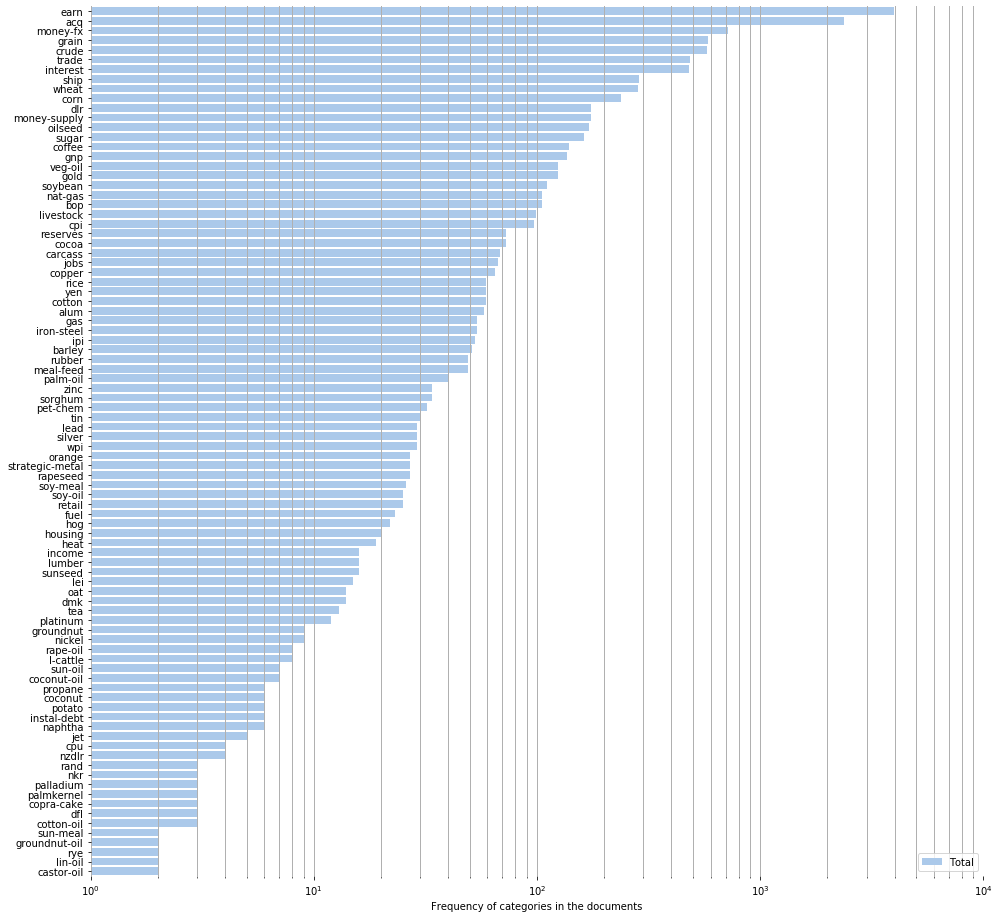

In [12]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 16))
# Log scale
ax.set_xscale('log')

# Plot the total crashes
sns.set_color_codes("pastel")
g = sns.barplot(x="frequency", y="categories", data=df_categories,
            label="Total", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(1, 10000), ylabel="", xlabel="Frequency of categories in the documents")
ax.grid(linestyle='-', linewidth=1, which='both', axis='x')
sns.despine(left=True, bottom=True)

One of the characteristics of this dataset are the imbalanced classe with 'earn' and a few more classes topping the number of cases. Due to this many standard algorithms will have difficulties since they are biased towards the majority class without consideration for the data distribution.

The worst scenario will have the minority classes considered as outliers and ignored which may be a real issue in cases like fraud detection. One possible tecnnique is to undersample or oversample the corresponding class.

## Text Representation

Most learning algorithms cannot process directly text documents and prefer numerical feature vectores with a fixed size rather than the raw text with variable length.

Therefore we have to represent and weight every document with respect to the set of textual features (e.g., the words that appear in the document). By applying the 'bag of words' model the occurance of words is taken into considration but not the order in which they appear in the document. Before this step, we have to clean the text so in total we are going to apply the following transformations:

* Lowercase the original content
* Tokenize the text
* Stem or lematize each one of the tokens
* Weight each of these features, for each document
* Normalise the representation

Clean up the documents.<br>
Remove accents and special characters, normalize the text, remove stopwords, lematize...

In [13]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from wordcloud import WordCloud

nltk.download('wordnet')

stop_word_list = stopwords.words('english')
# stop_word_list.remove('no')
# stop_word_list.remove('not')

token = ToktokTokenizer()
lemma = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jdelrio\anaconda3\envs\py37\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def text_replacements(text):
    text = text.lower()
    text = text.replace(r"i'm ", "i am ")
    text = text.replace(r"he's ", 'he is ')
    text = text.replace(r"she's ", 'she is ')
    text = text.replace(r"it's ", 'it is ')
    text = text.replace(r"\'s", ' ')
    text = text.replace(r"d\''", '')
    text = text.replace(r"\'ve ", " have ")
    text = text.replace(r"can't ", "cannot ")
    text = text.replace(r"what's ", "what is ")
    text = text.replace("\n", " ")
    
    text = text.replace("u.s.", "united states")
    text = text.replace(" ec ", " european community ")
    text = text.replace(" dlrs", " dollars")
    text = text.replace(" mln", " million")
    text = text.replace(" pct", " percentage")
    text = text.replace(" x ", " ")
    text = text.replace(" e ", " ")
    text = text.replace(" e.", " ")
    text = text.replace("1st ", "first ")
    text = text.replace("2nd ", "second ")
    text = text.replace("qtr", "quarter")
    text = text.replace("cts", "cents")
    text = text.replace("shr", "share")
    text = text.replace(" vs ", " versus ")
    text = text.replace(" inc ", " incorporated ")
    text = text.replace("wk", "week")
    text = text.replace("prev ", "previous ")
    
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\'", " ", text)
    text = re.sub(r"@", " ", text)
    text = re.sub(r" n't ", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"let\'s", "let us", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"y\'all", "you all", text)
    text = re.sub(r" doin\' ", " doing ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    # Extend with other cleaning text operations...
    return text

In [15]:
# Function to remove accents and normalize the text
def remove_accents(data):
    data = unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return data

In [16]:
# Remove special characters and digits
def remove_special(text):
    str = "`1234567890-=~@#$%^&*()_+[!{;”:\’'><.,/?”}]"
    for w in text:
        if w in str:
            text = text.replace(w, ' ')
    return text

def remove_stop_words(text):
    word_list = [x.strip() for x in token.tokenize(text)]
    removedList = [x for x in word_list if not x in stop_word_list]
    
    return ' '.join(removedList)

def lemmatize(text):
    # Reduce variations for inflections and derivations
    listLemma = []
    for w in [y.strip() for y in token.tokenize(text)]:
        x = lemma.lemmatize(w, 'v')
        listLemma.append(x)
    text = ' '.join(listLemma)
    return text

In [17]:
def text_pre_process(text):
    text = remove_accents(text)
    text = remove_special(text)
    text = remove_stop_words(text)
    return(text)

In [18]:
df['processed_text'] = df['text'].map(lambda t: text_replacements(t))
df['processed_text'] = df['processed_text'].map(lambda t: text_pre_process(t))
df['lematized'] = df['processed_text'].map(lambda t: lemmatize(t))

## Visual Representation of the words

First we gather all the entries in the dataest together

In [19]:
all_text = ' '.join(df['processed_text'].tolist())

### Worldcloud

Wordcloud creates a nice graph with the words in different sizes depending on how frequent these words are in the dataset. <br>
We customize the final result to avoid repetitions of the words by setting 'collocations' to False

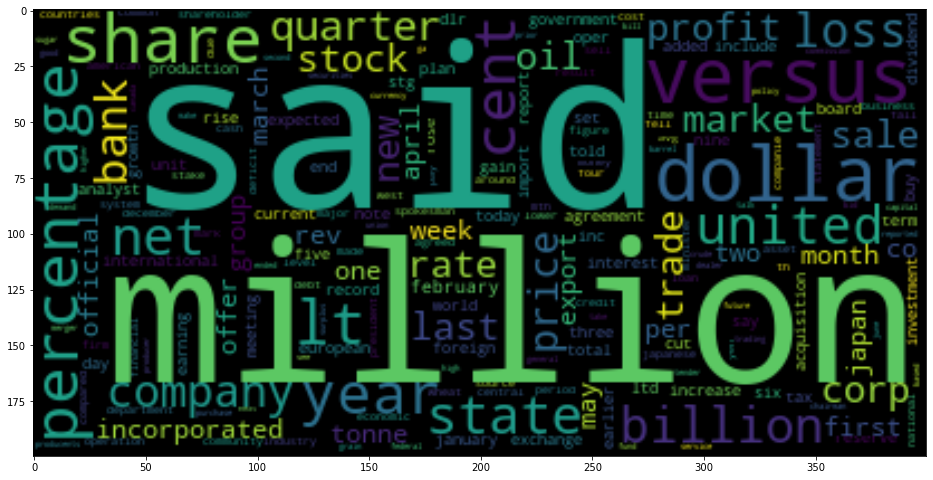

In [20]:
wc = WordCloud(max_font_size=100, 
               max_words=200, 
               collocations=False, 
               background_color='black').generate(all_text)
plt.figure(figsize=(16, 12))
plt.imshow(wc, interpolation='bilinear')

### Count per samples

Using the same set of words but now plotted using the more classical frequency distribution graph.

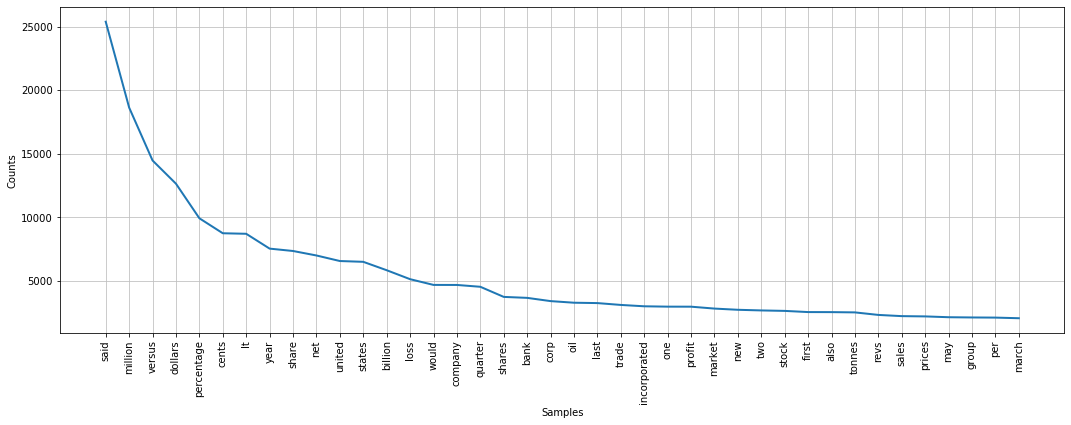

In [21]:
word_freq_dist = nltk.FreqDist(ToktokTokenizer().tokenize(all_text))
plt.figure(figsize=(18, 6))
word_freq_dist.plot(40)

### Word cound per entry

In [22]:
df['n_words'] = df['processed_text'].str.split(' ').apply(len)

Text(0, 0.5, 'Count')

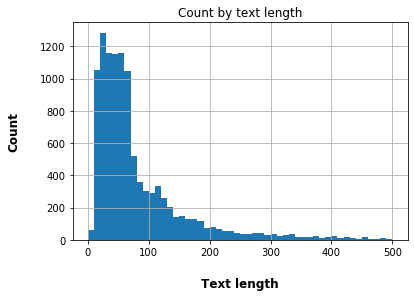

In [23]:
ax = df['n_words'].hist(bins=50, range=[0, 500])
ax.set_title("Count by text length")
ax.set_xlabel("Text length", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

The result shows a skewed distribution with a long left tail but most of the entries are below 100 words.

## Frequency Distribution of words per category

First we allocate each word with its corresponding category

In [24]:
genres = df_categories['categories']

def get_docs_with_genre(df, genre):
    includes_category = df['categories'].map(lambda x: genre in x)
    return df.loc[includes_category, 'processed_text']
    
# List of pairs genre-word
genre_word_pairs = [(genre, word)
                    for genre in genres
                    for word in ' '.join([*get_docs_with_genre(df, genre).values]).split()]
print('Length of pairs list: {}'.format(len(genre_word_pairs)))

Length of pairs list: 1244011


Now we use this list of pairs to create a ConditionalFreqDistWe can and save it in a variable. <br>We can type the name of the variable to inspect it and verify that it has two conditions

In [25]:
cfd = nltk.ConditionalFreqDist(genre_word_pairs)
from pprint import pprint as pp
print('Number of conditions: {}\nExample of first 5 conditions: {}'.format(
    len(cfd.conditions()), cfd.conditions()[:5]))

Number of conditions: 90
Example of first 5 conditions: ['earn', 'acq', 'money-fx', 'grain', 'crude']


Choosing the category 'barley' as example and the 20 most common words within that category, we obtain the following plot:

In [26]:
barley_most_common = cfd['barley'].most_common(20)
common_term, common_freq = zip(*barley_most_common)
common_barley_df = pd.DataFrame({'term': common_term, 'freq': common_freq})

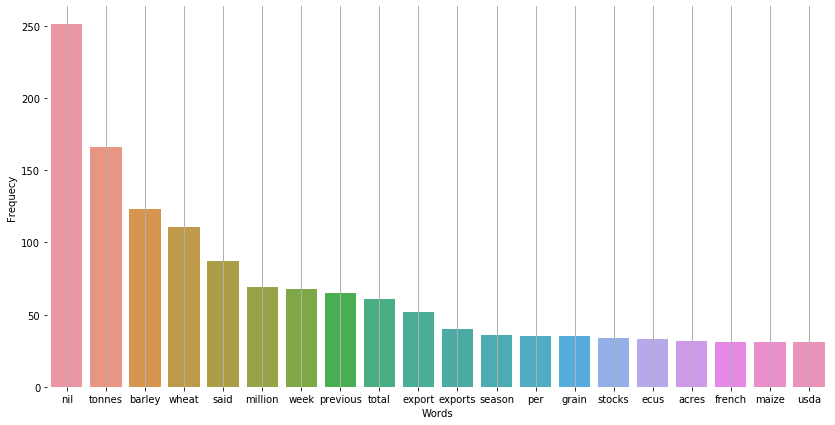

In [27]:
f, ax = plt.subplots(figsize=(14, 7))

# Plot the total crashes
sns.set_color_codes("pastel")
g = sns.barplot(x="term", y="freq", data=common_barley_df)

# Add a legend and informative axis label
ax.set(ylabel="Frequecy", xlabel="Words")
ax.grid(linestyle='-', linewidth=1, which='both', axis='x')
sns.despine(left=True, bottom=True)

In [ ]:
df_file = df.copy()
df_file['categories'] = df_file.categories.apply(json.dumps)
df_file.to_csv(OUTPUT_DATA, index=False)

## Extract features vectors

Now we want to weight each of feature as per its “importance” for the document.<br>

To explain in a simple way what "tf-idf" does, the terms weight is higher the more common the term is in the document, and the more uncommon in the collection. More detailed explenation at https://en.wikipedia.org/wiki/Tf%E2%80%93idf

The tf_idf function will convert the text to vectors and after that step we can use the new data to fit the model. <br>
When obtaining very long vectors there is the question if we really need that many features and we may be better off by selecting the best features instead of using them all. The method 'SelectKbest' allows to do precisely that (found in the sklearn.feature_selection package), after which Chi2 score can be used to select the features with the highest values for the test chi-squared.

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2

In [29]:
X_all = df['processed_text']
label_list = df_categories["categories"].values
nlabels = len(label_list)

def tf_idf(docs):
    tfidf = TfidfVectorizer(min_df=5,              # Minimum number of documents a word must be present in
                            tokenizer=token.tokenize,
                            max_features=3000,
                            use_idf=True,
                            sublinear_tf=True,     # Use logarithmic form for frequency
                            norm='l2')             # Ensure that all feature vectors have a euclidian norm of 1
    # Other parameters
    #   ngram_range set to (1, 2) to indicate that we want to consider both unigrams and bigrams
    #   
    #   max_df=0.90,
    tfidf.fit(docs)
    return tfidf

In [30]:
def feature_values(doc, representer):
    doc_representation = representer.transform([doc])
    features = representer.get_feature_names()
    return [(features[index], doc_representation[0, index])
                 for index in doc_representation.nonzero()[1]]

In [31]:
X_train = df[df['doc_set'] == 'train']['lematized']
y_train = df[df['doc_set'] == 'train']['categories']

X_test = df[df['doc_set'] == 'test']['lematized']
y_test = df[df['doc_set'] == 'test']['categories']

In [32]:
tfidf = tf_idf(X_train)

In [33]:
count = 0
for doc in df[df['doc_set'] == 'test']['lematized']:
    [pp(k) for k in feature_values(doc, tfidf)]
    count += 1
    if count >= 10:
        break

('yesterday', 0.03908705154846454)
('year', 0.04722938940617371)
('yasuhiro', 0.06578198288495891)
('would', 0.054368386594078326)
('worry', 0.06175647433726683)
('world', 0.06302717693223528)
('work', 0.04105259659007966)
('whose', 0.05890033056924751)
('whole', 0.05654410651080432)
('week', 0.033655825108509396)
('washington', 0.0491183111354744)
('warn', 0.054189852123167896)
('want', 0.043028575450705604)
('virtually', 0.06509701298657136)
('view', 0.08544121223434101)
('us', 0.052850356179887335)
('unite', 0.09883299303048856)
('two', 0.04506327824459336)
('trade', 0.10976900101961196)
('tough', 0.06385437757419712)
('tokyo', 0.08807527842142962)
('time', 0.03565740934373791)
('threat', 0.06224086921855204)
('third', 0.04320942062706294)
('textile', 0.06863812665297823)
('term', 0.07048472429822451)
('tell', 0.03123070982120116)
('tax', 0.03433382545542153)
('tariff', 0.1312874162240053)
('talk', 0.03948029604911289)
('taiwan', 0.12984535264950678)
('surplus', 0.09294323831859226)

('dispute', 0.16634734905822063)
('crew', 0.13740479585038748)
('council', 0.09232671488300649)
('could', 0.06553624563588303)
('container', 0.12887059109605986)
('compensation', 0.13411855864779232)
('commission', 0.07585126852147307)
('claim', 0.10437570506969102)
('change', 0.07240467248870083)
('carry', 0.09903447665352057)
('cargo', 0.19039555360344337)
('call', 0.07599522913942904)
('begin', 0.07683213369604172)
('ban', 0.25581588125634436)
('australian', 0.10142793118844588)
('australia', 0.10036528679399757)
('appear', 0.09871575796834639)
('ago', 0.07770734844475671)
('affect', 0.08959024346594349)
('action', 0.13817639431499196)
('would', 0.06201647776063654)
('worth', 0.06810725348231916)
('world', 0.052629748476222746)
('week', 0.0475837202402713)
('want', 0.06083522510538926)
('visit', 0.08140089635344122)
('value', 0.05519459353724533)
('users', 0.09516851497848268)
('use', 0.05427597618627991)
('us', 0.07472158400379306)
('undermine', 0.09704285679942665)
('two', 0.03762

Transform the labels to binary

In [34]:
def labels2binary(labels, label_list=label_list):
    return [1 if label in labels else 0 for label in label_list]

def bin2labels(df):
    labels = df.columns

In [35]:
y_bin_train = y_train.apply(labels2binary).tolist()
df_bin_labels = pd.DataFrame(y_bin_train, columns=label_list)
df_bin_labels.shape

(7769, 90)

Before analysing the models, we can use chi2 (sklearn.feature_selection.chi2) to find which terms are the most correlated with each of the categories.

In [36]:
tfidf = TfidfVectorizer(min_df=5,
                        tokenizer=token.tokenize,
                        max_features=3000,
                        use_idf=True,
                        sublinear_tf=True,
                        norm='l2')

features = tfidf.fit_transform(X_train)

In [37]:
N = 5
selected_features = {}
for idx, category in enumerate(label_list):
    selector = SelectKBest(chi2, k=10)                   # Select only 10 best features
    selector.fit(features, df_bin_labels.iloc[:, idx])
    indices = np.argsort(selector.scores_)               # Get indixes of the sorted array
    selected_features[category] = list(np.array(tfidf.get_feature_names())[indices])[-N:]
    n_tabs = (2-(floor(len(category) / 6)))
    print('{}: {}{}'.format(category, '\t'* n_tabs,', '.join(selected_features[category])))

earn: 		rev, loss, net, cents, versus
acq: 		merger, versus, acquisition, stake, acquire
money-fx: 	stg, dealers, yen, money, dollar
grain: 		maize, tonnes, corn, grain, wheat
crude: 		opec, bpd, oil, crude, barrel
trade: 		tariff, gatt, surplus, deficit, trade
interest: 	repurchase, bank, rat, prime, rate
ship: 		vessel, seamen, vessels, port, ship
wheat: 		winter, soft, barley, tonnes, wheat
corn: 		sorghum, unknown, bushel, maize, corn
dlr: 		tokyo, intervene, dealers, yen, dollar
money-supply: week, acceptances, supply, feed, money
oilseed: 	oilseeds, rapeseed, crushers, soybean, soybeans
sugar: 		rebate, cane, beet, white, sugar
coffee: 	ibc, bag, quotas, ico, coffee
gnp: 		product, growth, gross, gnp, gdp
veg-oil: 	oil, rbd, fat, vegetable, palm
gold: 		assay, ton, ounces, ounce, gold
soybean: 	corn, bean, bushel, soybeans, soybean
nat-gas: 	trillion, feet, natural, gas, cubic
bop: 		payments, narrow, account, surplus, deficit
livestock: 	pork, hog, slaughter, beef, cattle
cpi: 	

From this we can verify how the selection makes sense or not. For example for crude, selecting:

 * opec
 * bpd
 * oil
 * crude
 * barrel

## GaussianNB multi-class multi-label classification

In [38]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# Create pipeline with TfidfVectorizer and the classifier
binrel_clf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5,
                              tokenizer=token.tokenize,
                              max_features=3000,
                              use_idf=True,
                              sublinear_tf=True,
                              norm='l2')),
    ('clf', BinaryRelevance(GaussianNB())),
])

binrel_clf.fit(X_train, df_bin_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=3000,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<bound method ToktokTokenizer.tokenize of <nltk.tokenize.toktok.ToktokTokenizer object at 0x000000000EF2A7B8>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 BinaryRelevance(classifie

Get predictions for the test set and compare the predictions with the actual categories

In [39]:
y_pred = binrel_clf.predict(X_test)
df_pred = pd.DataFrame(y_pred.todense(), columns=label_list)
print('Predictions shape: {}'.format(df_pred.shape))

from itertools import compress
labels = df_pred.columns
predicted_labels = df_pred.apply(lambda x: list(compress(labels, x)), axis=1)
pd_comp = pd.DataFrame({'labels': y_test, 'predictions': predicted_labels})
pd_comp.head(7)

Predictions shape: (3019, 90)


,labels,predictions
0,[trade],[]
1,[grain],[]
2,"[crude, nat-gas]",[trade]
3,"[corn, grain, rice, rubber, sugar, tin, trade]",[grain]
4,"[palm-oil, veg-oil]",[]
5,[ship],[]
6,"[coffee, lumber, palm-oil, rubber, veg-oil]",[]


## MultinomialNB multi-class multi-label classification

More suitable for word counts is the multinomial variant:

In [40]:
from sklearn.naive_bayes import MultinomialNB

multinomial_csf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5,
                              tokenizer=token.tokenize,
                              max_features=3000,
                              use_idf=True,
                              sublinear_tf=True,
                              norm='l2')),
    ('clf', BinaryRelevance(MultinomialNB())),
])

multinomial_csf.fit(X_train, df_bin_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=3000,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<bound method ToktokTokenizer.tokenize of <nltk.tokenize.toktok.ToktokTokenizer object at 0x000000000EF2A7B8>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 BinaryRelevance(classifie

Again, we can have a quick look to asses how well the categories are predicted...

In [41]:
y_pred = multinomial_csf.predict(X_test)
df_pred = pd.DataFrame(y_pred.todense(), columns=label_list)

from itertools import compress
labels = df_pred.columns
predicted_labels = df_pred.apply(lambda x: list(compress(labels, x)), axis=1)
pd_comp = pd.DataFrame({'labels': y_test, 'predictions': predicted_labels})
pd_comp.head(7)

,labels,predictions
0,[trade],[trade]
1,[grain],[]
2,"[crude, nat-gas]",[]
3,"[corn, grain, rice, rubber, sugar, tin, trade]",[]
4,"[palm-oil, veg-oil]",[]
5,[ship],[ship]
6,"[coffee, lumber, palm-oil, rubber, veg-oil]",[]


Let's define the pipeline for a few more models and evaluate them all to understand the performance across the different models.

In [42]:
from sklearn.ensemble import RandomForestClassifier

rnd_forest = RandomForestClassifier(n_estimators=270, 
                                    max_depth=3, 
                                    random_state=42)
random_forest_csf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5,
                              tokenizer=token.tokenize,
                              max_features=3000,
                              use_idf=True,
                              sublinear_tf=True,
                              norm='l2')),
    ('clf', BinaryRelevance(rnd_forest)),
])

# random_forest_csf.fit(X_train, df_bin_labels)

In [43]:
from sklearn.tree import ExtraTreeClassifier

extra_tree_csf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5,
                              tokenizer=token.tokenize,
                              max_features=3000,
                              use_idf=True,
                              sublinear_tf=True,
                              norm='l2')),
    ('clf', ExtraTreeClassifier()),
])

# extra_tree_csf.fit(X_train, df_bin_labels)

In [44]:
from sklearn.ensemble import ExtraTreesClassifier

ensamble_trees_csf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5,
                              tokenizer=token.tokenize,
                              max_features=3000,
                              use_idf=True,
                              sublinear_tf=True,
                              norm='l2')),
    ('clf', ExtraTreesClassifier(n_estimators=270)),
])

# ensamble_trees_csf.fit(X_train.head(100), df_bin_labels.head(100))

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=3000,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='(...
                 ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                      criterion='gini', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
           

In [45]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

multiclass_svm_csf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5,
                              tokenizer=token.tokenize,
                              max_features=3000,
                              use_idf=True,
                              sublinear_tf=True,
                              norm='l2')),
    ('clf', OneVsRestClassifier(LinearSVC(random_state=42))),
])

# multiclass_svm_csf.fit(X_train.head(100), df_bin_labels.head(100))

Other models that we could evaluate:
* sklearn.neural_network.MLPClassifier
* sklearn.linear_model.RidgeClassifierCV
* sklearn.ensemble.RandomForestClassifier

## Model Scoring & Selection

In [46]:
# Get all the classifiers that we want to evaluate into the list of models...
models = [
    binrel_clf,
    multinomial_csf,
    random_forest_csf,
    extra_tree_csf,
    ensamble_trees_csf,
    multiclass_svm_csf,
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))      # Empty DataFrame to allocate scores
entries = []

# Score all models
for model in models:
    # Extract the model name from the pipeline classifier
    model_name = [(step[1].classifier.__class__.__name__ if hasattr(step[1], 'classifier') 
                   else step[1].__class__.__name__ ) for step in model.steps if step[0] == 'clf'][0]
    accuracies = cross_val_score(model, X_train, df_bin_labels, scoring='accuracy', cv=CV)
    
    for idx, accuracy in enumerate(accuracies):
        entries.append((model_name, idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_index', 'accuracy'])

C:\Users\jdelrio\anaconda3\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 79 is present in all training examples.
  str(classes[c]))
C:\Users\jdelrio\anaconda3\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 85 is present in all training examples.
  str(classes[c]))
C:\Users\jdelrio\anaconda3\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 89 is present in all training examples.
  str(classes[c]))
C:\Users\jdelrio\anaconda3\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 82 is present in all training examples.
  str(classes[c]))
C:\Users\jdelrio\anaconda3\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 80 is present in all training examples.
  str(classes[c]))
C:\Users\jdelrio\anaconda3\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 86 is present in all training examples.
  str(classes[c]))
C:\Users\jdelrio\anaco

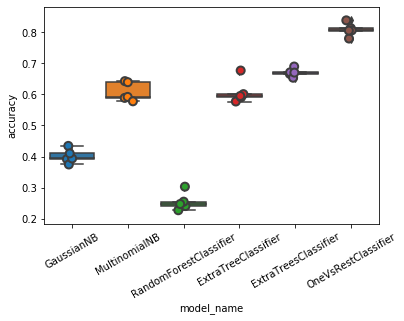

In [47]:
g = sns.boxplot(x='model_name', y='accuracy', data=cv_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [48]:
cv_df.groupby('model_name').accuracy.mean()

model_name
ExtraTreeClassifier       0.608185
ExtraTreesClassifier      0.670228
GaussianNB                0.400954
MultinomialNB             0.608190
OneVsRestClassifier       0.808727
RandomForestClassifier    0.254601
Name: accuracy, dtype: float64

## Model Evaluation

After the previous scoring we select the model and we are going to look at the confusion matrix and the discrepancies between predicted and actual categories.

Note: Multi-class multi-label is not supported... let me know if you know of this

In [49]:
multiclass_svm_csf.fit(X_train, df_bin_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=3000,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='(...
                                 tokenizer=<bound method ToktokTokenizer.tokenize of <nltk.tokenize.toktok.ToktokTokenizer object at 0x000000000EF2A7B8>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(

In [50]:
y_pred = multiclass_svm_csf.predict(X_test)
df_pred = pd.DataFrame(y_pred, columns=label_list)

from itertools import compress
labels = df_pred.columns
predicted_labels = df_pred.apply(lambda x: list(compress(labels, x)), axis=1)
pd_comp = pd.DataFrame({'labels': y_test, 'predictions': predicted_labels})
pd_comp.head(7)

,labels,predictions
0,[trade],[trade]
1,[grain],[grain]
2,"[crude, nat-gas]",[crude]
3,"[corn, grain, rice, rubber, sugar, tin, trade]",[trade]
4,"[palm-oil, veg-oil]","[veg-oil, palm-oil]"
5,[ship],[ship]
6,"[coffee, lumber, palm-oil, rubber, veg-oil]","[coffee, rubber]"


In [51]:
unpack_labels = []

def unpacking(row):
    unpack_found = []
    unpack_missing = []
    pred = row['predictions'].copy()
    for m in row['labels']:
        if m in pred:
            pred.remove(m)
            unpack_found.append((m, m))
        else:
            unpack_missing.append((m, 'unknown'))
    
    n_pred = len(pred)
    if n_pred == 1:
        for i, m in enumerate(unpack_missing):
            unpack_missing[i] = (m[0], pred[0])
    elif (n_pred > 1) and (n_pred < len(unpack_missing)):
        for i, m in enumerate(pred):
            unpack_missing[i] = (m[0], pred[i])
    elif (n_pred > 1) and (n_pred > len(unpack_missing)):
        for i, m in enumerate(unpack_missing):
            unpack_missing[i] = (m[0], pred[i])
    unpack_found.extend(unpack_missing)
    return unpack_found

# Get the pairs of category-prediction
pairs_df = pd_comp.apply(lambda row: unpacking(row), axis=1)
# Flatten the list of lists
flat_pairs = [item for sublist in pairs_df.values for item in sublist]
# Create dataframe
df_flat = pd.DataFrame(flat_pairs, columns=['actual', 'prediction'])

### Confusion Matrix

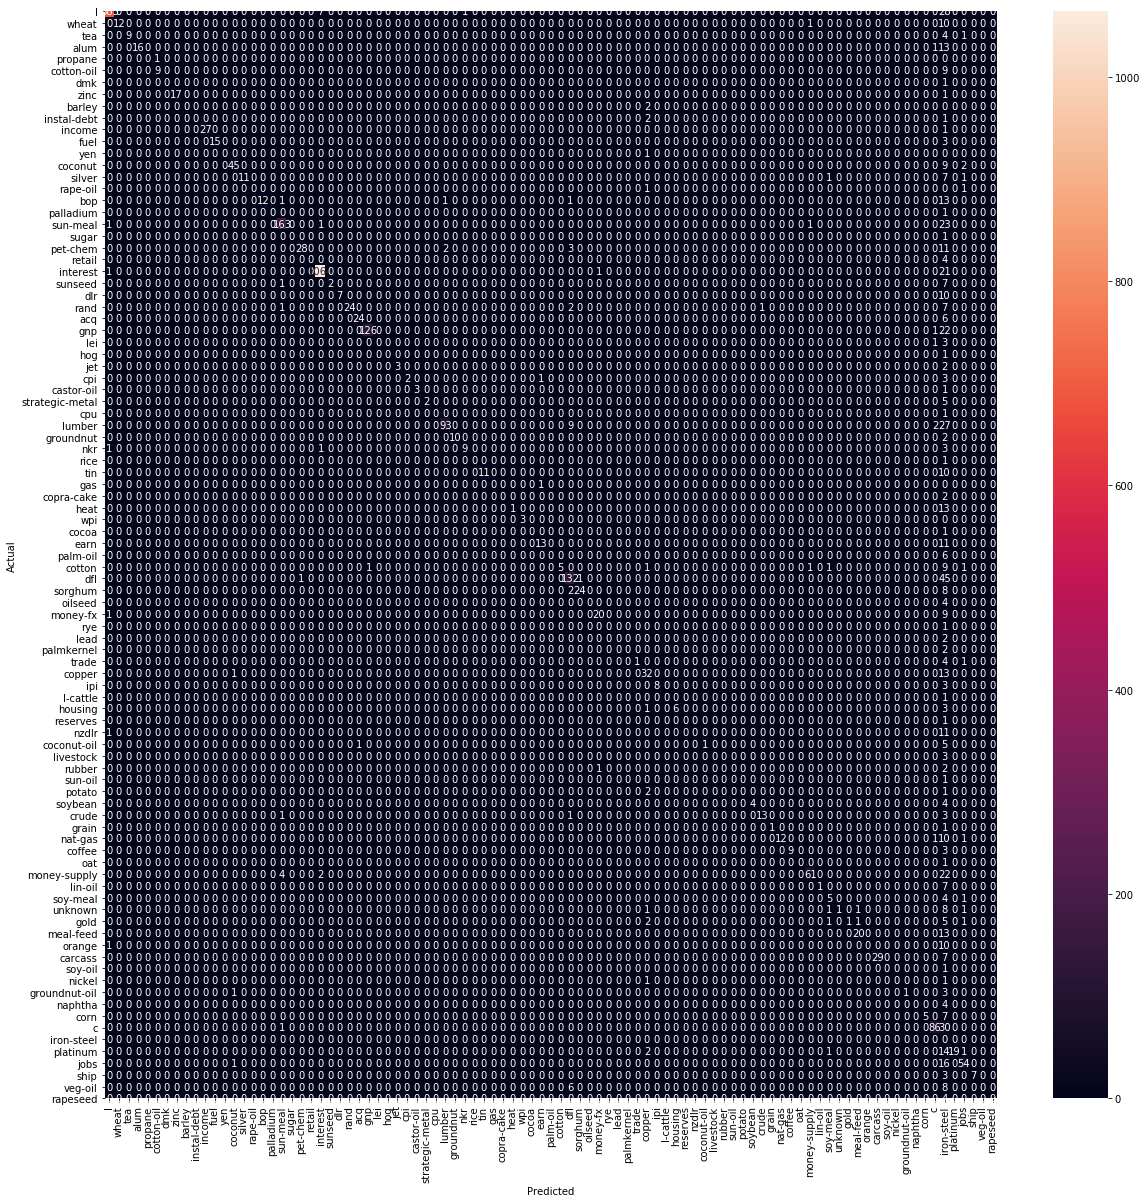

In [52]:
conf_mat = confusion_matrix(df_flat.actual, df_flat.prediction)

fig, ax = plt.subplots(figsize=(20,20))
matrix_labels = set([*df_flat.actual, *df_flat.prediction])
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=matrix_labels, yticklabels=matrix_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Classification Report

In [53]:
from sklearn import metrics

print(metrics.classification_report(df_flat.actual, df_flat.prediction, target_names=matrix_labels))

                 precision    recall  f1-score   support

              l       0.99      0.95      0.97       719
          wheat       1.00      0.52      0.69        23
            tea       1.00      0.64      0.78        14
           alum       1.00      0.53      0.70        30
        propane       0.00      0.00      0.00         1
     cotton-oil       0.90      0.50      0.64        18
            dmk       0.00      0.00      0.00         1
           zinc       1.00      0.94      0.97        18
         barley       0.00      0.00      0.00         2
    instal-debt       0.00      0.00      0.00         3
         income       1.00      0.96      0.98        28
           fuel       1.00      0.83      0.91        18
            yen       0.00      0.00      0.00         1
        coconut       0.94      0.80      0.87        56
         silver       1.00      0.55      0.71        20
       rape-oil       0.00      0.00      0.00         2
            bop       1.00    

As observed the precision depends on the category considered and there are some categories for which the accuracy is very low. These categories are mostly the ones in which we have very few test cases to train our model which is to be expected considering how inbalanced are the distribution of cases per categories.